Tutorial 5: Noise Map Scaling 2
===============================

Noise-map scaling is important when our mass model lead to an inaccurate source reconstruction . However, it serves an
even more important use, when another component of the lens model does not fit the data well. Can you think what it is?
What could leave significant residuals in our model-fit? What might happen to also be the highest S/N values in our
image, meaning these residuals contribute *even more* to the chi-squared distribution?

It`s the lens galaxy's light. Just like an overly simplified mass profile`s means we can not perfectly reconstruct
the source's light, the same is true of the Sersic profiles we use to fit the lens galaxy's light.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

we'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is an `EllSersic`.
 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear`.
 - The source galaxy's `LightProfile` is an `EllSersic`.

In [2]:
dataset_name = "light_sersic__mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=3.0,
)

imaging = imaging.apply_mask(mask=mask)

Again, we'll use a convenience function to fit the lens data we simulated above.

In [3]:


def fit_imaging_with_lens_and_source_galaxy(imaging, lens_galaxy, source_galaxy):

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    return al.FitImaging(imaging=imaging, tracer=tracer)


Now, lets use this function to fit the lens data. we'll use a lens model with the correct mass model but an incorrect 
lens `LightProfile`. The source will use a magnification based grid.

Evidence using baseline variances =  -754.9442236744972


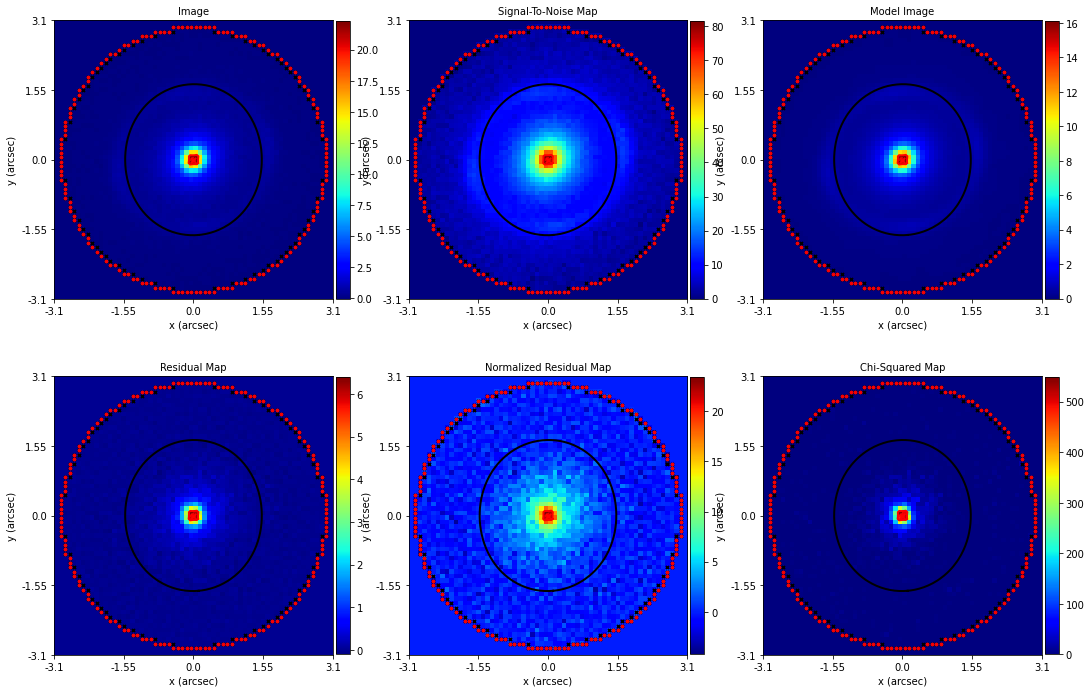

In [4]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    bulge=al.lp.EllSersic(
        centre=(0.0, 0.0),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, angle=45.0),
        intensity=0.8,
        effective_radius=0.8,
        sersic_index=4.0,
    ),
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, angle=45.0),
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
)

source_magnification = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiMagnification(shape=(30, 30)),
    regularization=al.reg.Constant(coefficient=3.3),
)

fit = fit_imaging_with_lens_and_source_galaxy(
    imaging=imaging, lens_galaxy=lens_galaxy, source_galaxy=source_magnification
)

print("Evidence using baseline variances = ", fit.log_evidence)

include_2d = aplt.Include2D(mapper_data_pixelization_grid=True, mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()

__Lens Subtraction__

Okay, so its clear that our poor lens light subtraction leaves residuals in the lens galaxy's centre. These pixels 
are extremely high S/N, so they contribute large chi-squared values. For a real strong lens, we could not fit these 
residual features using a more complex light profile. These types of residuals are extremely common and they are 
caused by nasty, irregular morphological structures in the lens galaxy; nuclear star emission, nuclear rings, bars, etc.

This skewed chi-squared distribution will cause all the same problems we discussed in the previous tutorial, like 
over-fitting. However, for the source-reconstruction and Bayesian evidence the residuals are even more problematic 
than before. Why? Because when we compute the Bayesian evidence for the source-inversion these pixels are included 
like all the other image pixels. But, __they do not contain the source__. The Bayesian evidence is going to try 
improve the fit to these pixels by reducing the level of regularization,  but its __is going to fail miserably__, as 
they map nowhere near the source!

This is a fundamental problem when simultaneously modeling the lens galaxy's light and source galaxy. The source 
inversion has no way to distinguish whether the flux it is reconstructing belongs to the lens or source. This is 
why contribution maps are so valuable; by creating a contribution map for every galaxy in the image **PyAutoLens** has a 
means by which to distinguish which flux belongs to each component in the image! This is further aided by the 
pixelization and regularizations  adapting to the source morphology, as not only are they adapting to where the 
source is located they are adapting to where it is not (and therefore where the lens galaxy is).

__Contribution Maps__

Lets now create our hyper-images and use them create the contribution maps of our lens and source galaxies. 
Note below that we now create separate model images for our lens and source galaxies. This allows us to create 
contribution maps for each.

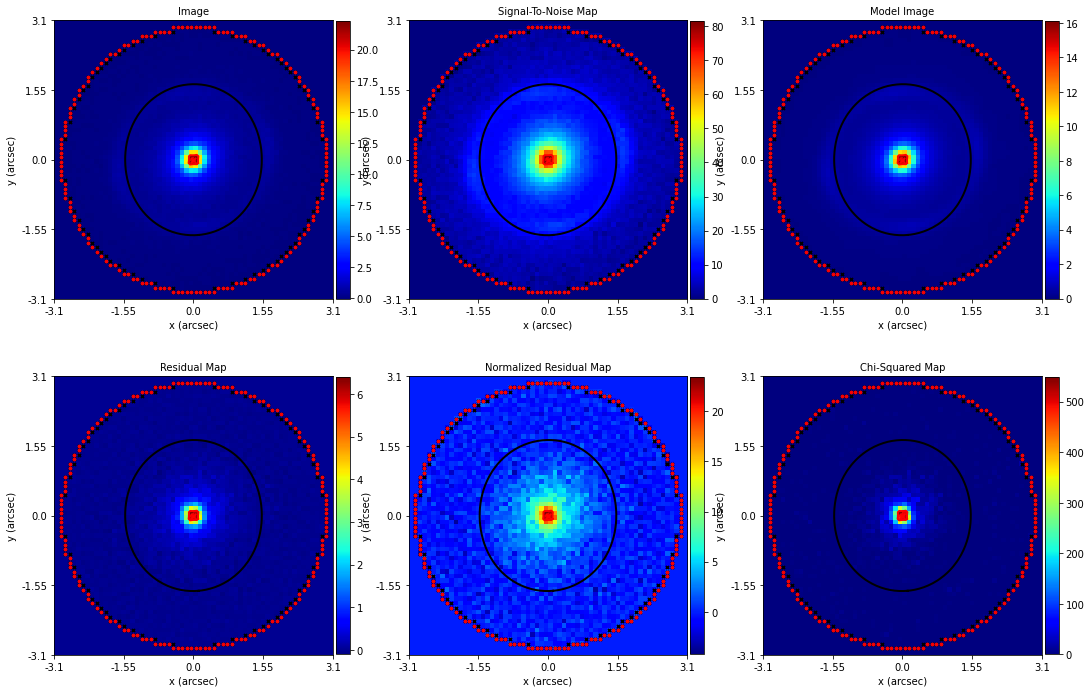

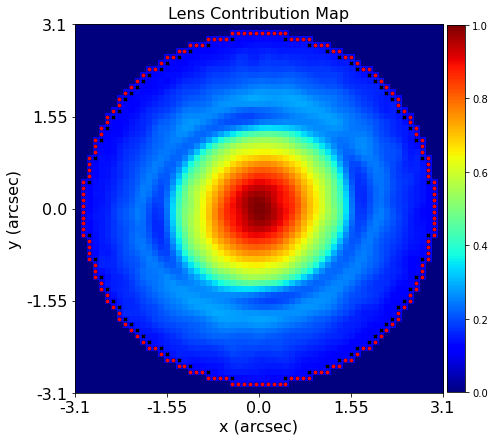

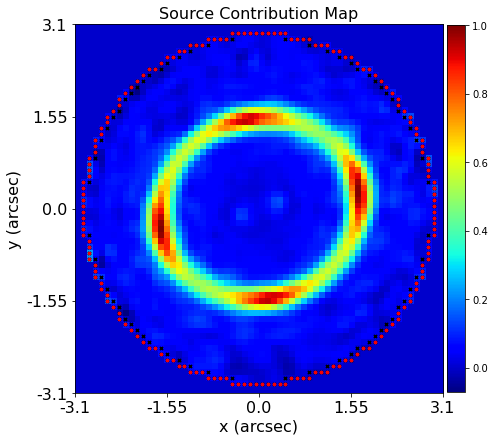

In [5]:
hyper_image = fit.model_image.slim

hyper_image_lens = fit.model_images_of_planes[0]  # This is the model image of the lens

hyper_image_source = fit.model_images_of_planes[
    1
]  # This is the model image of the source

lens_galaxy_hyper = al.Galaxy(
    redshift=0.5,
    bulge=al.lp.EllSersic(
        centre=(0.0, 0.0),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, angle=45.0),
        intensity=0.8,
        effective_radius=0.8,
        sersic_index=4.0,
    ),
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0), elliptical_comps=(0.111111, 0.0), einstein_radius=1.6
    ),
    hyper_galaxy=al.HyperGalaxy(
        contribution_factor=0.3, noise_factor=4.0, noise_power=1.5
    ),
    hyper_model_image=hyper_image,
    hyper_galaxy_image=hyper_image_lens,  # <- The lens get its own hyper-galaxy image.
)

source_magnification_hyper = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiMagnification(shape=(30, 30)),
    regularization=al.reg.Constant(coefficient=3.3),
    hyper_galaxy=al.HyperGalaxy(
        contribution_factor=2.0, noise_factor=2.0, noise_power=3.0
    ),
    hyper_galaxy_image=hyper_image,
    hyper_model_image=hyper_image_source,  # <- The source get its own hyper-galaxy image.
)

fit = fit_imaging_with_lens_and_source_galaxy(
    imaging=imaging, lens_galaxy=lens_galaxy, source_galaxy=source_magnification
)
fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()

lens_contribution_map = lens_galaxy_hyper.hyper_galaxy.contribution_map_from_hyper_images(
    hyper_model_image=hyper_image, hyper_galaxy_image=hyper_image_lens
)


array_plotter = aplt.Array2DPlotter(array=lens_contribution_map)
array_plotter.set_title("Lens Contribution Map")
array_plotter.figure_2d()

source_contribution_map = source_magnification_hyper.hyper_galaxy.contribution_map_from_hyper_images(
    hyper_model_image=hyper_image, hyper_galaxy_image=hyper_image_source
)

array_plotter = aplt.Array2DPlotter(array=source_contribution_map)
array_plotter.set_title("Source Contribution Map")
array_plotter.figure_2d()

The contribution maps decompose the image into its different components. Next, we use each contribution map to scale 
different regions of the noise-map. From the fit above it was clear that both the lens and source required the noise to 
be scaled, but their different chi-squared values ( > 150 and ~ 30) means they require different levels of noise-scaling. 

Lets see how much our fit improves and Bayesian evidence increases.

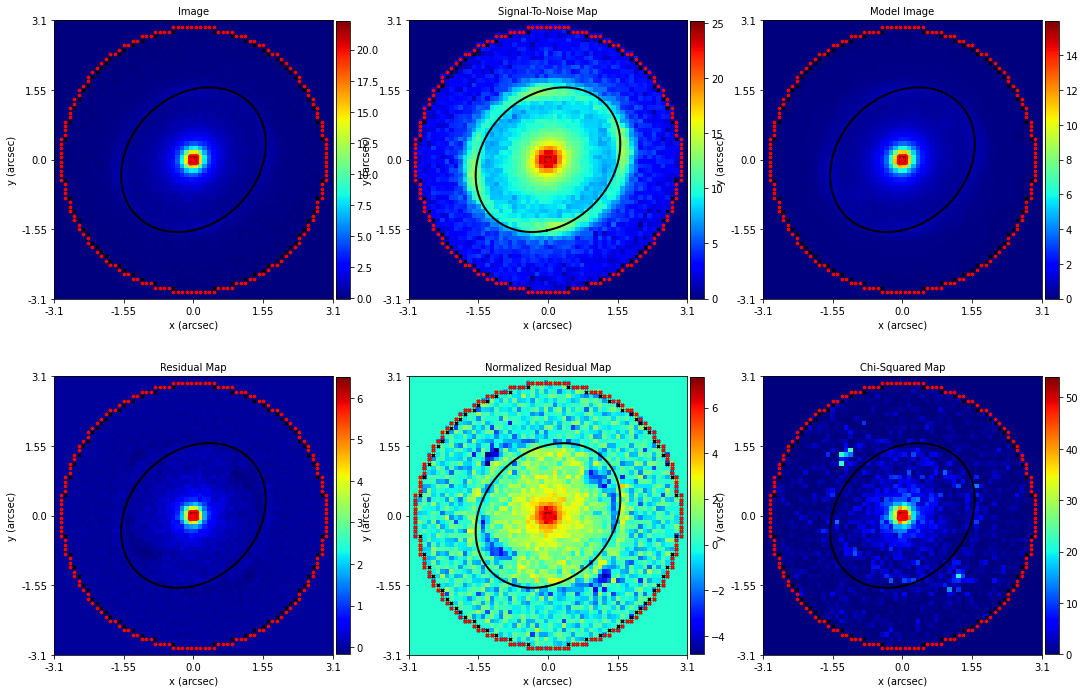

Evidence using baseline variances =  492.0612
Evidence using hyper-galaxy hyper variances =  3227.918466833542


In [6]:
fit = fit_imaging_with_lens_and_source_galaxy(
    imaging=imaging,
    lens_galaxy=lens_galaxy_hyper,
    source_galaxy=source_magnification_hyper,
)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()

print("Evidence using baseline variances = ", 492.0612)

print("Evidence using hyper-galaxy hyper variances = ", fit.log_evidence)

Great, and with that, we've covered hyper galaxies. You might be wondering, what happens if there are multiple lens 
galaxies? or multiple source galaxies? Well, as you`d expect, **PyAutoLens** will make each a hyper-galaxy and 
therefore scale the noise-map of that individual galaxy in the image. This is what we want, as different parts of 
the image require different levels of noise-map scaling.

__Hyper Data__

Finally, I want to quickly mention two more ways that we change our data during th fitting process. One scales the 
background noise and one scales the image's background sky. To do this, we use the `hyper_data` module in **PyAutoLens**.

This module includes all components of the model that scale parts of the data. To scale the background sky in the 
image we use the `HyperImageSky` class and input a `sky_scale`.

In [7]:
hyper_image_sky = al.hyper_data.HyperImageSky(sky_scale=1.0)

The sky_scale is literally just a constant value we add to every pixel of the observed image before fitting it 
therefore increasing or decreasing the background sky level in the image. This means we can account for an 
inaccurate background sky subtraction in our data reduction during **PyAutoLens** model fitting.

We can also scale the background noise in an analogous fashion, using the `HyperBackgroundNoise` class and the 
`noise_scale` hyper-galaxy-parameter. This value is added to every pixel in the noise-map.

In [8]:
hyper_background_noise = al.hyper_data.HyperBackgroundNoise(noise_scale=1.0)

To use these hyper-galaxy-instrument parameters, we pass them to a lens-fit just like we do our `Tracer`.

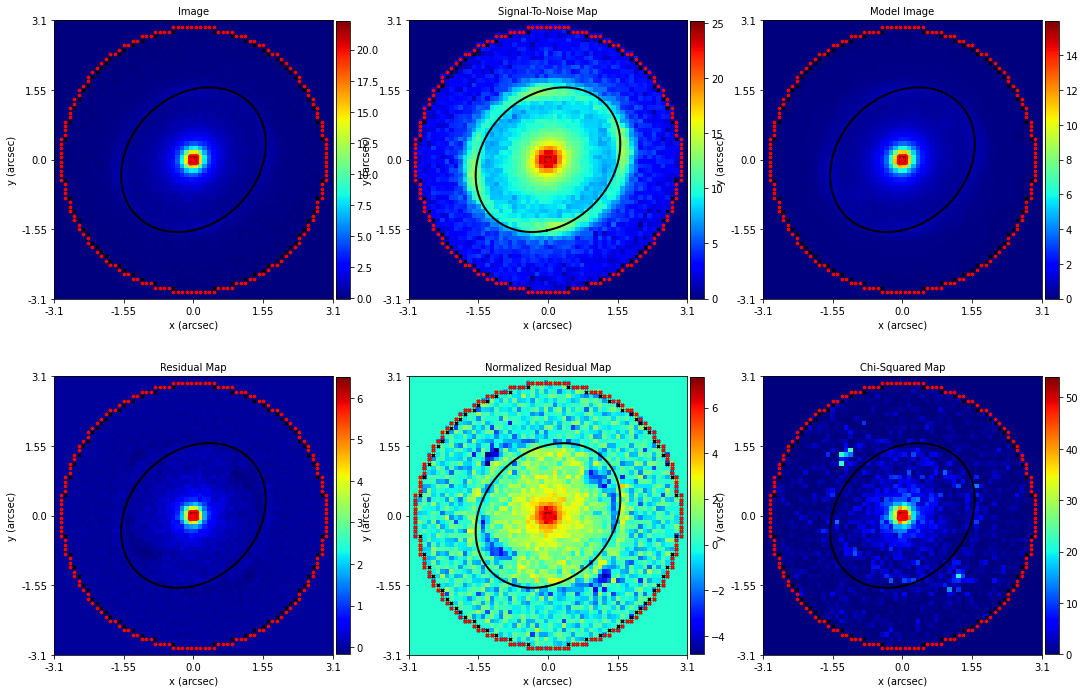

In [9]:
tracer = al.Tracer.from_galaxies(
    galaxies=[lens_galaxy_hyper, source_magnification_hyper]
)

al.FitImaging(
    imaging=imaging,
    tracer=tracer,
    hyper_image_sky=hyper_image_sky,
    hyper_background_noise=hyper_background_noise,
)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()

__Wrap Up__

Is there any reason to scale the background noise other than if the background sky subtraction has a large 
correction? There is. Lots of pixels in an image do not contain the lensed source but are fitted by the 
inversion. As we've learnt in this chapter, this isn't problematic when we have our adaptive regularization scheme 
because the regularization coefficient will be increased to large values.

However, if you ran a full **PyAutoLens** model-fit in hyper-mode (which we cover in the next tutorial), you will
find the method still dedicates a lot of source-pixels to fit these regions of the image, __even though they have no 
source__. Why is this? Its because although these pixels have no source, they still have a relatively high S/N values 
(of order 5-10) due to the lens galaxy (e.g. its flux before it is subtracted). The inversion when reconstructing the 
data `sees` pixels with a S/N > 1 and therefore wants to fit them with a high resolution.

By increasing the background noise these pixels will go to much lower S/N values (<  1). The adaptive pixelization will
feel no need to fit them properly and begin to fit these regions of the source-plane with far fewer, much bigger 
source pixels! This will again give us a net increase in Bayesian evidence, but more importantly, it will dramatically 
reduce the number of source pixels we use to fit the data. And what does fewer source-pixels mean? Much, much faster
run times. Yay!

With that, we have introduced every feature of hyper-galaxy-mode. The only thing left for us to do is to bring it 
all together and consider how we use all of these features in **PyAutoLens** pipelines. That is what we'll discuss in 
the next tutorial, and then you'll be ready to perform your own hyper-fits!